In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

# import plotting stuff
from utils.plot_utils import *

# import data loading stuff
from utils.data_utils import load_movement_df


path_to_data = os.path.join('..', '..', 'data')
# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [3]:
path_to_save = os.path.join(results_dir, "real_testing", "amro_observations")

In [4]:
import seaborn as sns

specimens_inference = ["ESCHERICHIA COLI", "KLEBSIELLA PNEUMONIAE", "PSEUDOMONAS AERUGINOSA", "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",
                            "STAPHYLOCOCCUS EPIDERMIDIS", "CANDIDA ALBICANS", "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS", "ENTEROCOCCUS FAECALIS"]

sites_inference     = ['Urine', 'Blood', 'Other', 'Respiratory', 'CSF']

posterior_df = []
for specimen in specimens_inference:
    for site in sites_inference:
        try:
            path_to_save_pid = os.path.join(path_to_save, "cluster_level_leave_one_out", f"not_{site}", '_'.join( specimen.lower().split()) )
            posterior        = np.load(os.path.join(path_to_save_pid, 'weekly_samples.npz'))
            # Posterior in last iteration
            param_iter       = posterior["param_post_iter"][:,:,-1]

            p_df          = pd.DataFrame(columns=["gamma", "beta", "amro"])
            p_df["gamma"] = param_iter[0,:]
            p_df["beta"]  = param_iter[1,:]
            p_df["amro"]  = specimen
            p_df["site_out"]  = site
            posterior_df.append(p_df)

        except:
            continue

for specimen in specimens_inference:
    #specimen         = specimens_inference[0]
    path_to_save_pid = os.path.join(path_to_save, "cluster_level_corrected", '_'.join( specimen.lower().split()) )
    posterior        = np.load(os.path.join(path_to_save_pid, 'weekly_samples.npz'))
    # Posterior in last iteration
    param_iter       = posterior["param_post_iter"][:,:,-1]

    p_df              = pd.DataFrame(columns=["gamma", "beta", "amro"])
    p_df["gamma"]     = param_iter[0,:]
    p_df["beta"]      = param_iter[1,:]
    p_df["amro"]      = specimen
    p_df["site_out"]  = "All"

    posterior_df.append(p_df)

posterior_df = pd.concat(posterior_df, ignore_index=True)


def specimen2title(specimen):
    sp_title = specimen
    if specimen == "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS":
        sp_title = "MSSA"
    elif specimen == "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS":
        sp_title = "MRSA"
    elif specimen == "STAPHYLOCOCCUS EPIDERMIDIS":
        sp_title = "S. Epidermis"
    elif sp_title == "ESCHERICHIA COLI":
        sp_title = "E. Coli"
    elif sp_title == "KLEBSIELLA PNEUMONIAE":
        sp_title = "K. Pneumoniae"
    elif sp_title == "PSEUDOMONAS AERUGINOSA":
        sp_title = "P. Aeruginosa"
    elif sp_title == "CANDIDA ALBICANS":
        sp_title = "C. Albicans"
    elif sp_title == "ENTEROCOCCUS FAECALIS":
        sp_title = "E. Faecalis"
    return sp_title

posterior_df["amro"] = posterior_df["amro"].apply(specimen2title)


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


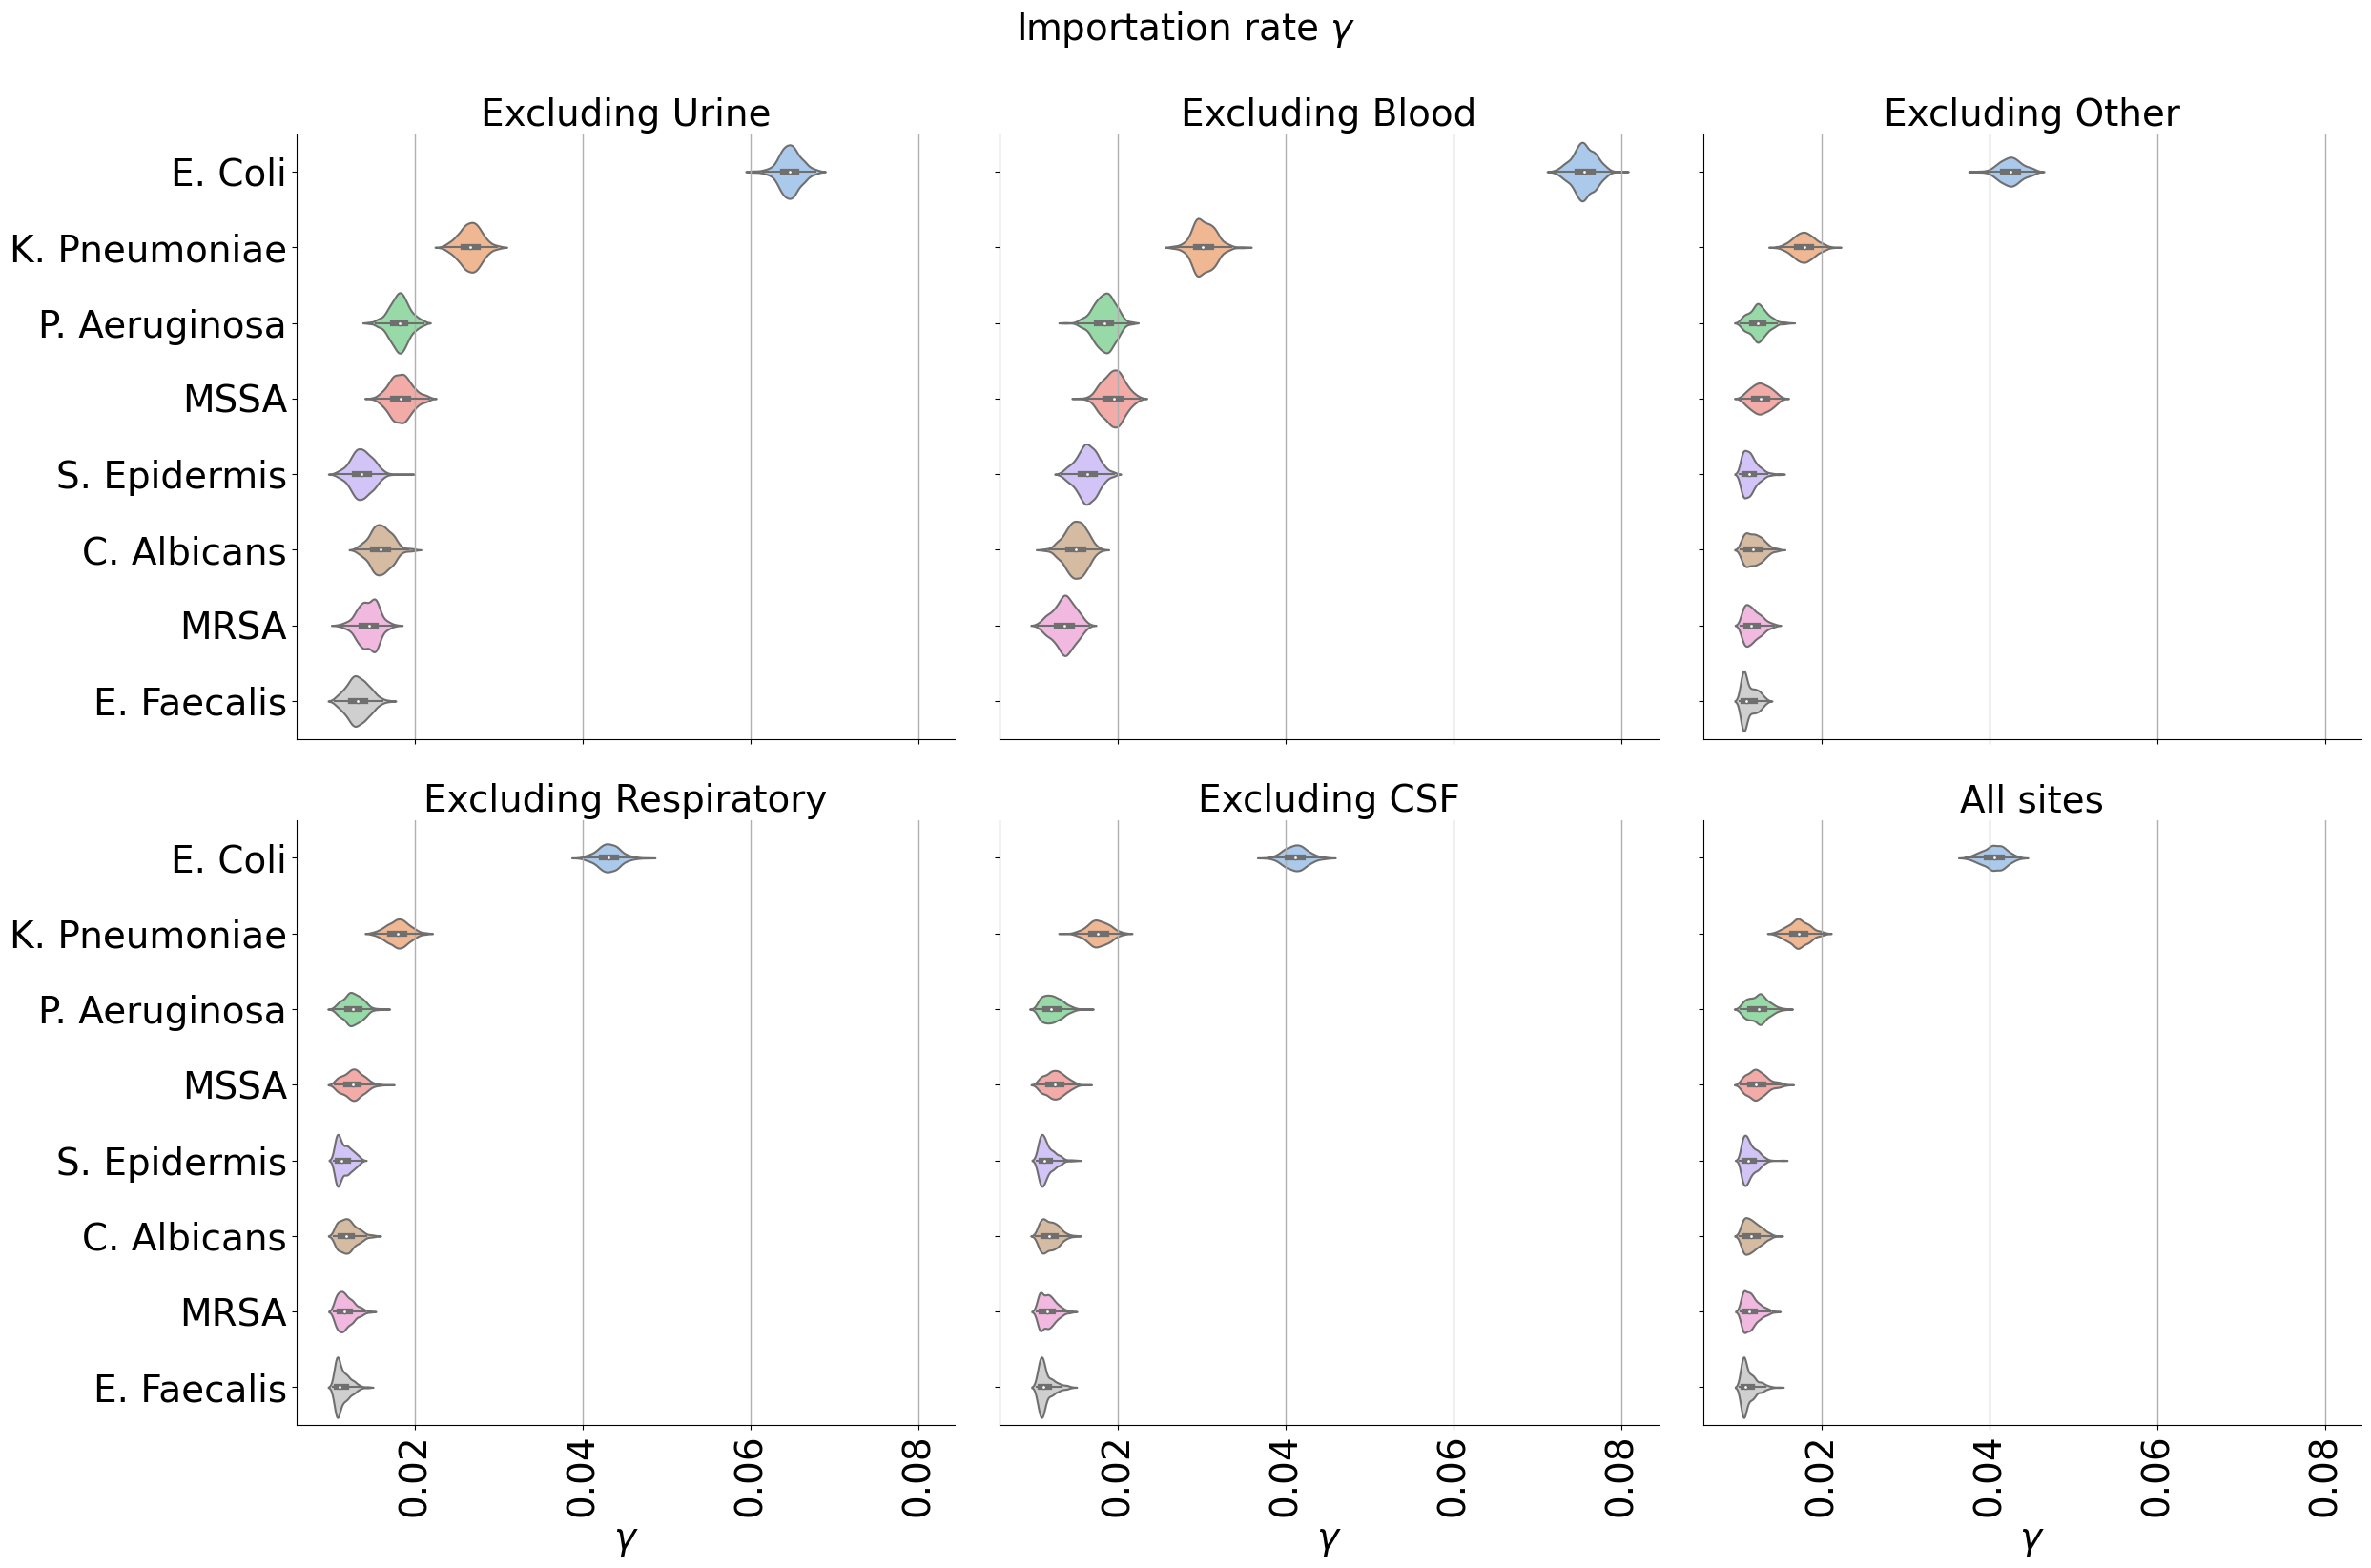

In [5]:
# First figure: Violin plots MLEs

grid = sns.FacetGrid(posterior_df, col="site_out", col_wrap=3, height=8.5, sharey=True)
grid.map(sns.violinplot,  "gamma", "amro", palette=sns.color_palette("pastel",n_colors=len(specimens_inference)))

#grid.axes[0].set_ylabel(r"$\gamma$")
for idx, ax in enumerate(grid.axes.flatten()):
    ax.tick_params(which='both', axis='x', labelrotation=90)
    if idx==5:
        ax.set_title("All sites")

    else:
        ax.set_title("Excluding "+sites_inference[idx])
    ax.grid(linestyle='-', linewidth=1, axis="x")

    ax.set_xlabel(r"$\gamma$")
    ax.set_ylabel(None)

plt.suptitle(r"Importation rate $\gamma$")
plt.tight_layout()

path_to_save  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "SensitivityObsNetwork_gamma.png")
grid.fig.savefig(path_to_save, dpi=300, transparent=True)



/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


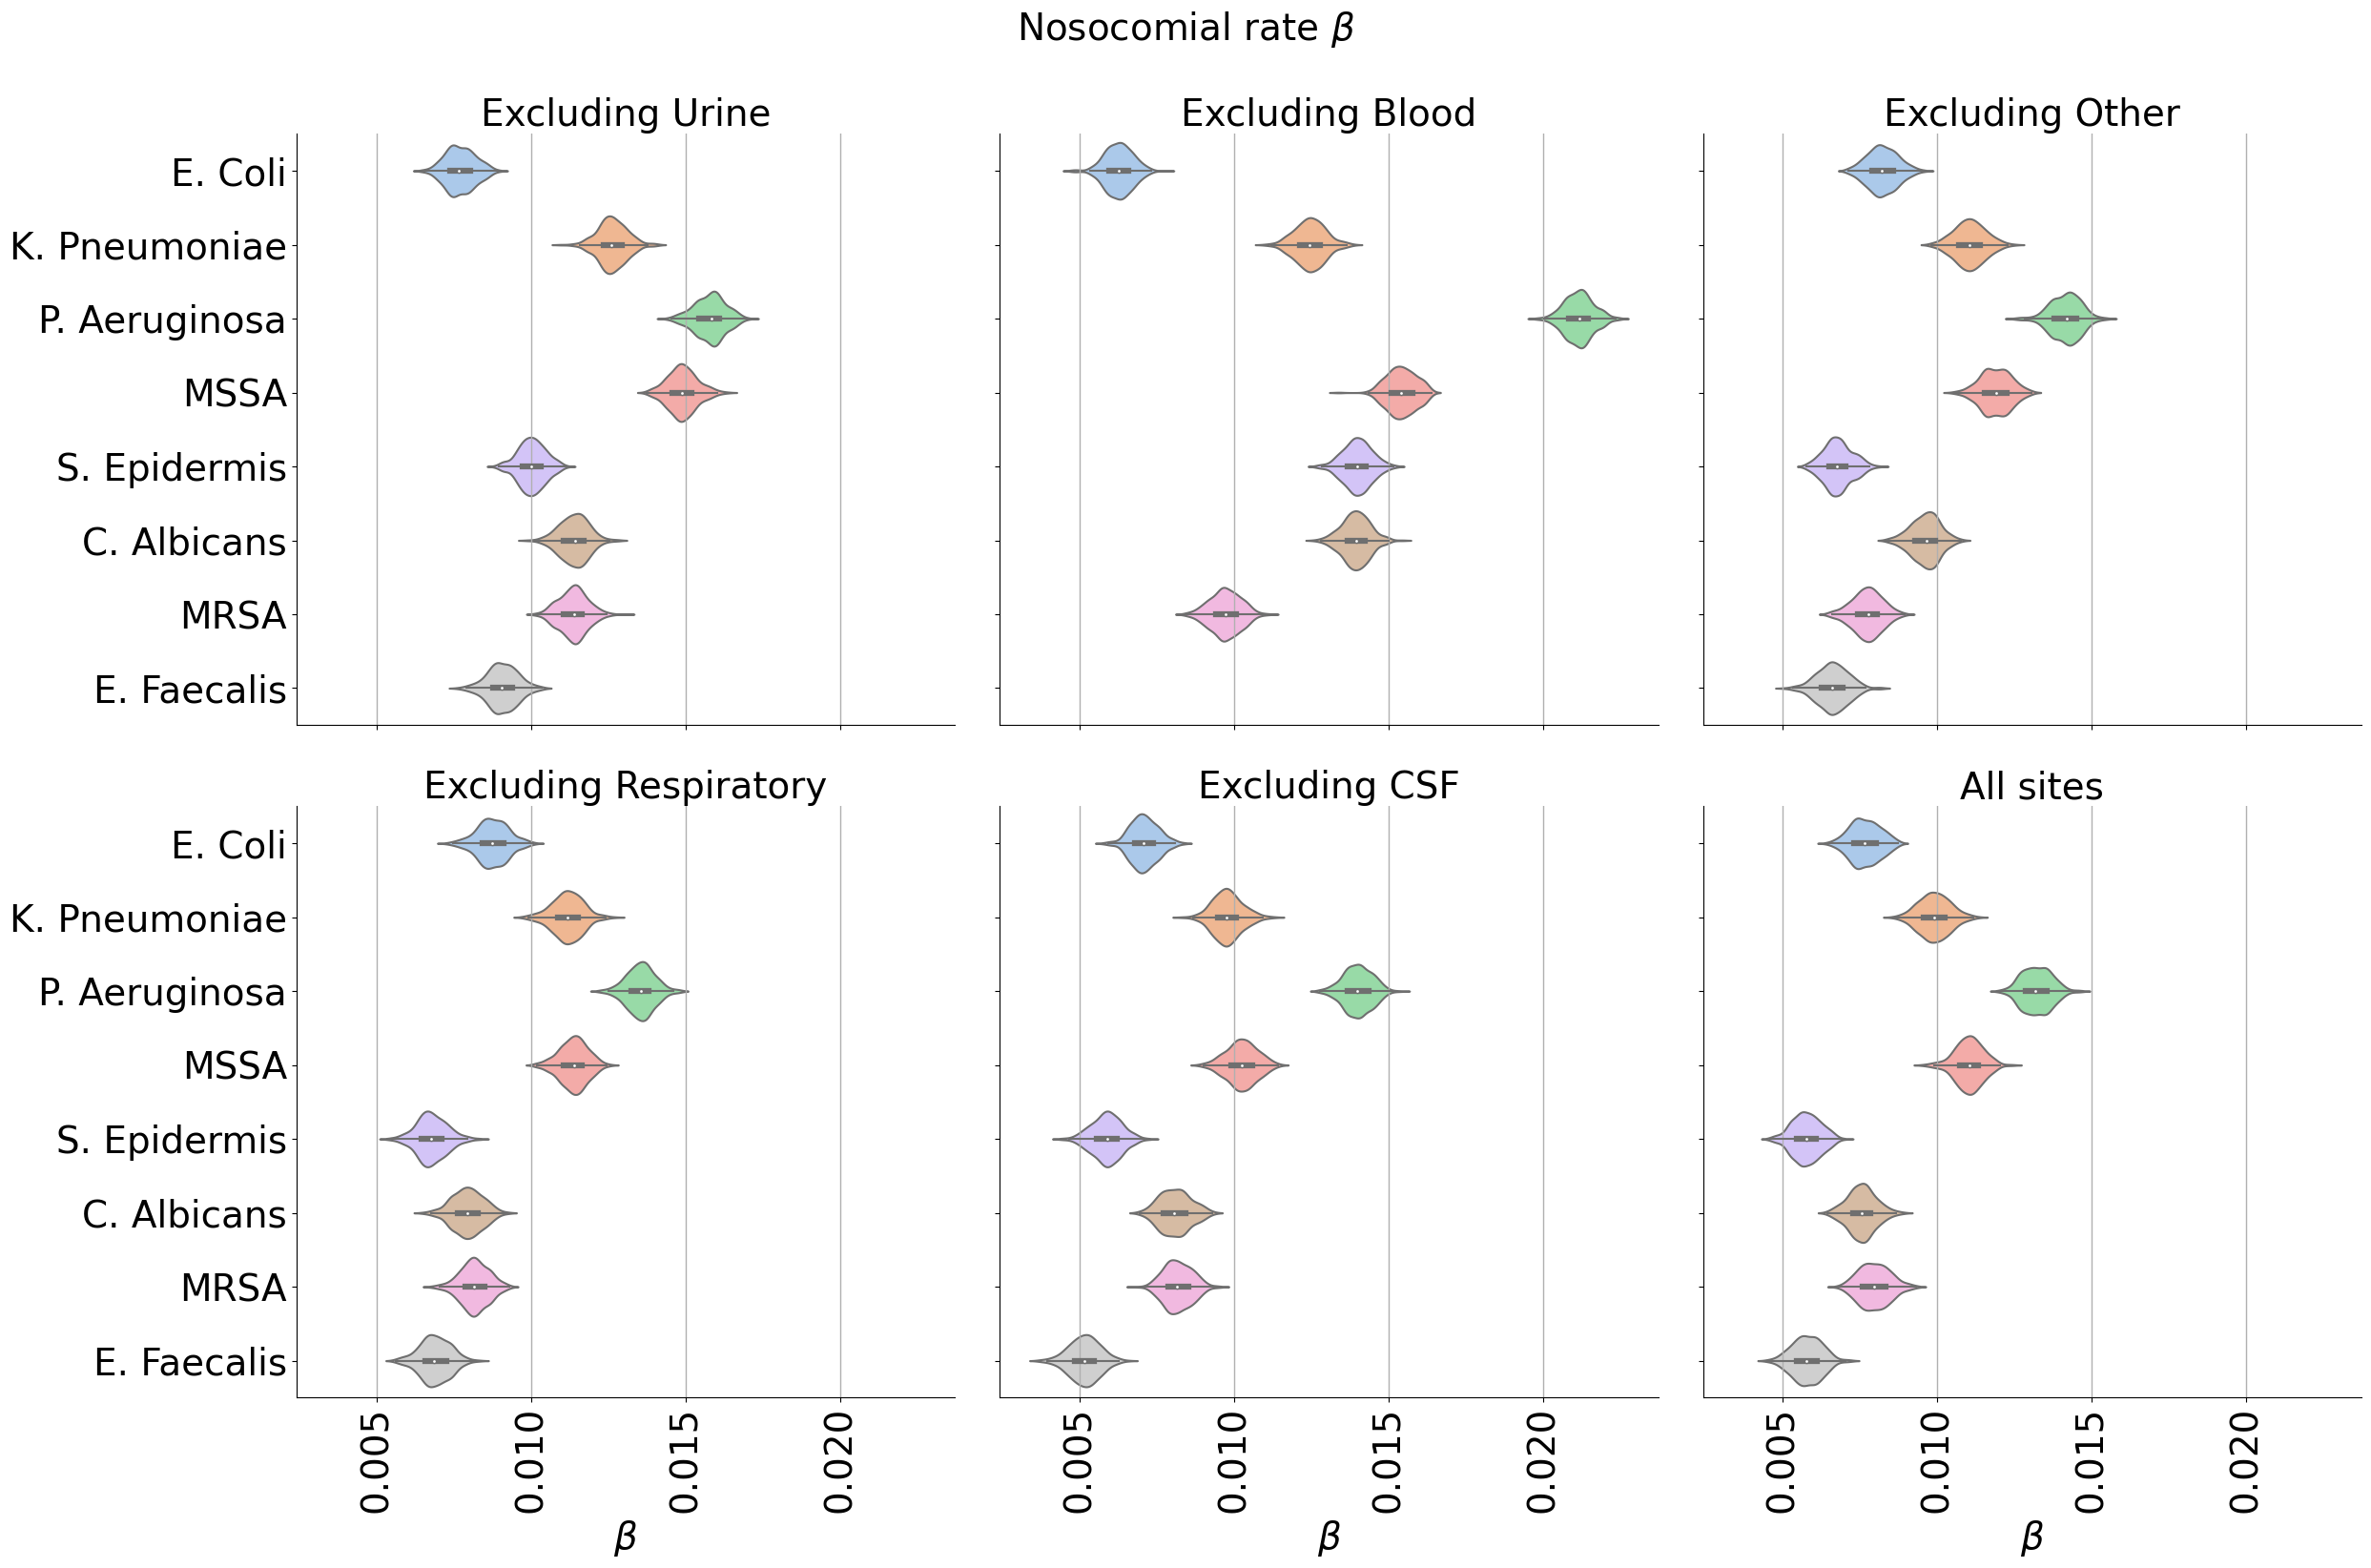

In [10]:
# First figure: Violin plots MLEs

grid = sns.FacetGrid(posterior_df, col="site_out", col_wrap=3, height=8.5, sharey=True)
grid.map(sns.violinplot,  "beta", "amro", palette=sns.color_palette("pastel",n_colors=len(specimens_inference)))

for idx, ax in enumerate(grid.axes.flatten()):
    ax.tick_params(which='both', axis='x', labelrotation=90)
    if idx==5:
        ax.set_title("All sites")

    else:
        ax.set_title("Excluding "+sites_inference[idx])
    ax.grid(linestyle='-', linewidth=1, axis="x")

    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(None)

plt.suptitle(r"Nosocomial rate $\beta$")
plt.tight_layout()

path_to_save  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "SensitivityObsNetwork_beta.png")
grid.fig.savefig(path_to_save, dpi=300, transparent=True)
